In [1]:
!pip install gradio

In [2]:
!pip install torch


In [3]:
!pip install torchvision


In [4]:
!pip install torchmetrics

In [5]:
pip install torchtext

In [6]:
import math
import os
import pickle
import re
from collections import defaultdict
from pathlib import Path
import gradio as gr
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.text import ROUGEScore
# from torchtext.metrics import bleu_score
from torchvision import transforms
from torchvision.models import convnext_small
from torchvision.transforms import Normalize, ToPILImage, ToTensor
from transformers import GPT2Tokenizer

In [8]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Caption 0: A black and brown dog is running on the beach .
Caption 1: A brown and black dog walks along a rocky beach .
Caption 2: A dog running on the beach .
Caption 3: a shepherd breed dog running on the beach
Caption 4: A wet German Shepherd runs along the waves on a beach .


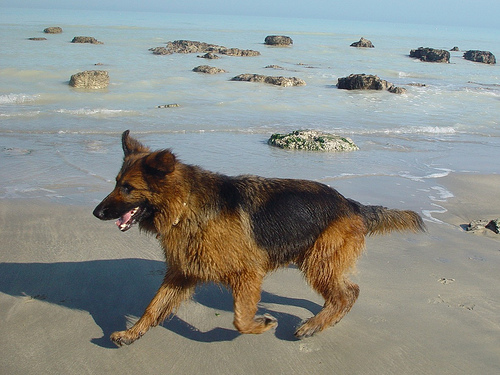

In [7]:
# explore datasets
img_dir = "/content/drive/MyDrive/flickr-8k/images/Flicker8k_Dataset"
text_dir = "/content/drive/MyDrive/flickr-8k/text/Flickr8k_text"

# load the captions for the given image
captions = pd.read_csv(Path(text_dir, "Flickr8k.token.txt"), sep="\t", names=["image_name", "caption"])

images = os.listdir(img_dir)
index = np.random.randint(0, len(images))
selected_file = images[index]

selected_captions = captions[captions["image_name"].apply(lambda x: x[:-2]) == selected_file]["caption"].tolist()
for idx, caption in enumerate(selected_captions):
    print(f"Caption {idx}: {caption}")

Image.open(Path(img_dir, selected_file))

In [10]:
class ResizePadTransform:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, image):
        # Calculate the aspect ratio of the original image
        width, height = image.size
        aspect_ratio = width / height

        # Determine the size after resizing while preserving the aspect ratio
        if width > height:
            new_width = self.target_size
            new_height = int(self.target_size / aspect_ratio)
        else:
            new_height = self.target_size
            new_width = int(self.target_size * aspect_ratio)

        # Define a torchvision transform to resize the image
        resize_transform = transforms.Resize((new_height, new_width))

        # Resize the image using the defined transform
        resized_image = resize_transform(image)

        # Calculate the padding required to achieve the target size
        pad_width = self.target_size - new_width
        pad_height = self.target_size - new_height

        # If pad is odd, then it will have issues, so you need to fix it
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        # Create a padding transform using torchvision
        padding_transform = transforms.Pad((pad_left, pad_top, pad_right, pad_bottom))

        # Apply the padding transform to the resized image
        padded_resized_image = padding_transform(resized_image)

        return padded_resized_image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

tfms = transforms.Compose([
    ResizePadTransform(224),
    ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens(
    {"bos_token": "<|startoftext|>", "unk_token": "<|unk|>", "pad_token": "[PAD]"}
)

print(tokenizer.encode("A cat is playing."))
print(tokenizer.decode(tokenizer.encode("This is a cat playing.")))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

[32, 3797, 318, 2712, 13]
This is a cat playing.


In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, data_split, transform=None, tokenizer=None, max_len=50, phase="train"):
        self.img_folder = Path(root_dir, "images", "Flicker8k_Dataset")
        self.text_folder = Path(root_dir, "text", "Flickr8k_text")
        split_file = Path(self.text_folder,
                          f"Flickr_8k.{data_split}Images.txt")

        self.images = pd.read_csv(split_file, names=["image_name"])
        self.captions = pd.read_csv(Path(self.text_folder, "Flickr8k.token.txt"),
                                    names=["image_name", "caption"],
                                    sep="\t")

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.phase = phase

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.phase == "train":
            caption_row = self.captions.iloc[idx]
            caption = caption_row["caption"]
            caption = f"{self.tokenizer.bos_token} {caption} {self.tokenizer.eos_token}"
            caption = self.tokenizer.encode(caption)

            pad_tokens = self.max_len - len(caption) + 1
            caption += pad_tokens * [self.tokenizer.pad_token_id]
            caption = torch.tensor(caption)

            image_name = caption_row["image_name"][:-2]
            image = Image.open(Path(self.img_folder, image_name))
            image = self.transform(image)
        else:
            image_name = self.images["image_name"][idx]
            image = Image.open(Path(self.img_folder, image_name))
            image = self.transform(image)

            caption = self.captions[self.captions["image_name"].str.contains(
                image_name)]["caption"].tolist()

        return {"image": image, "caption": caption, "image_name": image_name}

train_dataset = CustomImageDataset(root_dir = "/content/drive/MyDrive/flickr-8k", data_split = "train", transform=tfms, tokenizer=tokenizer)
eval_dataset = CustomImageDataset(root_dir = "/content/drive/MyDrive/flickr-8k", data_split = "dev", transform=tfms, tokenizer=tokenizer)
test_dataset = CustomImageDataset(root_dir = "/content/drive/MyDrive/flickr-8k", data_split = "test", transform=tfms, tokenizer=tokenizer)

print(len(train_dataset), len(eval_dataset), len(test_dataset))

print(train_dataset[100]["caption"])
print(tokenizer.decode(train_dataset[100]["caption"].tolist()))

6000 1000 1000
tensor([50257,  4930,  1180, 29580,   286,  7586,   290,  2330,  6844,   711,
          319,   262, 10481,   764,   220, 50256, 50259, 50259, 50259, 50259,
        50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
        50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
        50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
        50259])
<|startoftext|> Two different breeds of brown and white dogs play on the beach . <|endoftext|>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


In [13]:
BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(len(train_dataloader))
print(len(eval_dataloader))
print(len(test_dataloader))

750
125
125


In [14]:
def get_cnn_model():
    model = convnext_small(
        weights=torchvision.models.convnext.ConvNeXt_Small_Weights.IMAGENET1K_V1)
    model = nn.Sequential(*list(model.children())[:-2])

    return model

model = get_cnn_model()

print(model(torch.rand(8,3,224,224)).shape)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:01<00:00, 103MB/s]


torch.Size([8, 768, 7, 7])


In [15]:
# sinusoidal PositionalEncoding class

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [16]:
NUM_LAYERS = 6
EMB_DIM = 768
NHEAD = 8
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1
ACTIVATION = "gelu"

class TransformerDecoder(nn.Module):
    def __init__(
        self,
        emb_size,
        nhead,
        num_decoder_layers,
        tgt_vocab_size,
        dim_feedforward,
        dropout,
        activation,
    ):
        super(TransformerDecoder, self).__init__()

        self.emb_size = emb_size

        self.embedding = nn.Embedding(tgt_vocab_size, emb_size)
        self.text_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=emb_size,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation=activation,
            ),
            num_decoder_layers,
        )

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.init_weights()

    def init_weights(self):
        range = 0.1
        self.embedding.weight.data.uniform_(-range, range)
        self.generator.bias.data.zero_()
        self.generator.weight.data.uniform_(-range, range)

    def forward(self, src_emb, tgt_tokens, tgt_mask, tgt_padding_mask):
        B, D, H, W = src_emb.shape
        src_emb = src_emb.reshape(B, D, -1).permute(2, 0, 1)
        src_emb = self.positional_encoding(src_emb)

        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)
        tgt_emb = tgt_emb.permute(1, 0, 2)
        tgt_emb = self.positional_encoding(tgt_emb)

        outs = self.text_decoder(
            tgt_emb, src_emb, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask
        )

        return self.generator(outs)

    def generate(self, img_ft, tgt_tokens):
        src_emb = self.positional_encoding(img_ft)
        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)
        tgt_emb = tgt_emb.permute(1, 0, 2)
        tgt_emb = self.positional_encoding(tgt_emb)

        outs = self.text_decoder(tgt_emb, src_emb)

        return self.generator(outs)

class CaptionModel(nn.Module):
    def __init__(
        self,
        emb_size,
        nhead,
        num_decoder_layers,
        tgt_vocab_size,
        dim_feedforward,
        dropout,
        activation,
    ):
        super(CaptionModel, self).__init__()

        self.image_encoder = get_cnn_model()
        self.text_decoder = TransformerDecoder(
            emb_size,
            nhead,
            num_decoder_layers,
            tgt_vocab_size,
            dim_feedforward,
            dropout,
            activation,
        )

    def forward(self, img_op, tgt_tokens, tgt_mask, tgt_padding_mask):
        src_emb = self.image_encoder(img_op)
        text_op = self.text_decoder(src_emb, tgt_tokens, tgt_mask, tgt_padding_mask)

        return text_op

model = CaptionModel(
    emb_size=EMB_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_LAYERS,
    tgt_vocab_size=len(tokenizer),
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    activation=ACTIVATION,
)

In [17]:
criterion = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [19]:
NUM_EPOCHS = 100
transformer_learning_rate = 1e-5
cnn_learning_rate = 1e-5

optimizer_cnn = torch.optim.AdamW(
    model.image_encoder.parameters(), lr=cnn_learning_rate
)
optimizer_transformer = torch.optim.AdamW(
    model.text_decoder.parameters(), lr=transformer_learning_rate
)

scheduler_cnn = CosineAnnealingLR(optimizer_cnn, T_max=NUM_EPOCHS)
scheduler_transformer = CosineAnnealingLR(optimizer_transformer, T_max=NUM_EPOCHS)

In [20]:
# code to generate a mask for the target to ignore the future sequences

def create_mask(src, tgt, pad_idx):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    tgt_padding_mask = (tgt == pad_idx)
    return tgt_mask, tgt_padding_mask


def generate_square_subsequent_mask(sz, device="cpu"):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [21]:
NUM_EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

In [ ]:


exp_dir = "/content/drive/MyDrive/flickr-8k/Caption_Output"
writer = SummaryWriter(exp_dir)

checkpoint_epoch = 5

def train():
    for e in range(NUM_EPOCHS):
        model.train()
        train_running_loss = 0.0
        i = 0

        for idx, data in enumerate(train_dataloader):
            imgs = data["image"].to(device=DEVICE)
            target = data["caption"].to(device=DEVICE)

            target_in = target[:, :-1]
            target_out = target[:, 1:]

            model.zero_grad(set_to_none=True)
            tgt_mask, tgt_padding_mask = create_mask(
                imgs, target_in, pad_idx=tokenizer.pad_token_id)

            logits = model(imgs, target_in, tgt_mask.to(
                DEVICE), tgt_padding_mask.to(DEVICE))

            T, B, D = logits.shape

            loss = criterion(
                logits.permute(1, 0, 2).reshape(T*B, D), target_out.reshape(T*B))
            writer.add_scalar("loss/train", loss, (e * NUM_EPOCHS + idx))

            loss.backward()
            optimizer_cnn.step()
            optimizer_transformer.step()

            train_running_loss += loss.item()
            i += 1

        scheduler_cnn.step()
        scheduler_transformer.step()

        train_epoch_loss = train_running_loss / i

        writer.add_scalar("epoch_loss/train", train_epoch_loss, e)
        print(f"train loss after epoch {e+1}: {train_epoch_loss}")

        if (e + 1) % checkpoint_epoch == 0:
            model.eval()
            eval_running_loss = 0.0
            i = 0

            with torch.no_grad():
                for idx, data in enumerate(eval_dataloader):
                    imgs = data["image"].to(device=DEVICE)
                    target = data["caption"].to(device=DEVICE)

                    target_in = target[:, :-1]
                    target_out = target[:, 1:]

                    tgt_mask, tgt_padding_mask = create_mask(
                        imgs, target_in, pad_idx=tokenizer.pad_token_id)

                    logits = model(imgs, target_in, tgt_mask.to(
                        DEVICE), tgt_padding_mask.to(DEVICE))

                    T, B, D = logits.shape

                    loss = criterion(
                        logits.permute(1, 0, 2).reshape(T*B, D), target_out.reshape(T*B))

                    eval_running_loss += loss.item()
                    i += 1

                eval_epoch_loss = eval_running_loss / i

                writer.add_scalar("epoch_loss/eval", eval_epoch_loss, e)
                print(f"eval loss after epoch {e+1}: {eval_epoch_loss}")

            torch.save(model.state_dict(),
                       f"{exp_dir}/model_epoch_{e}.pt")
train()

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


train loss after epoch 1: 5.46479869778951
train loss after epoch 2: 4.054826664924621
train loss after epoch 3: 3.606307536760966
train loss after epoch 4: 3.2946773745218914
train loss after epoch 5: 3.0449146501223248
eval loss after epoch 5: 2.5414372663497926
train loss after epoch 6: 2.833294533252716
train loss after epoch 7: 2.6576078689893086
train loss after epoch 8: 2.4920089920361836
train loss after epoch 9: 2.347308298587799
train loss after epoch 10: 2.216244911670685
eval loss after epoch 10: 1.7146254196166992
train loss after epoch 11: 2.094720934708913
train loss after epoch 12: 1.9911160318056742
train loss after epoch 13: 1.8925551509857177
train loss after epoch 14: 1.801770088036855
train loss after epoch 15: 1.7107760206858318
eval loss after epoch 15: 1.2322512755393982
train loss after epoch 16: 1.6306716976165772
train loss after epoch 17: 1.5572561498483022
train loss after epoch 18: 1.481981318394343
train loss after epoch 19: 1.4082677645683288
train loss 

KeyboardInterrupt: 

In [22]:
model_state = torch.load("/content/drive/MyDrive/flickr-8k/Caption_Output/model_epoch_74.pt", map_location=DEVICE)
model.load_state_dict(model_state)
model = model.eval()

<ipython-input-22-01206803afc1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load("/content/drive/MyDrive/flickr-8k/Caption_Output/model_epoch_74.pt"

In [23]:
def eval_collate(batch_data):
    images = batch_data[0]["image"].unsqueeze(0)
    caption = batch_data[0]["caption"]
    image_name = batch_data[0]["image_name"]

    data = {"image": images, "caption": caption, "image_name": image_name}

    return data

eval_dataset = CustomImageDataset(
    root_dir="/content/drive/MyDrive/flickr-8k/",
    data_split="dev",
    transform=tfms,
    tokenizer=tokenizer,
    phase="test",
)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, collate_fn=eval_collate)

pred_results = defaultdict(list)

model = model.eval()

with torch.no_grad():
    for idx, data in enumerate(eval_dataloader):
        imgs = data["image"].to(DEVICE)
        references = data["caption"]
        image_name = data["image_name"]

        # preprocess captions
        img_ftr = model.image_encoder(imgs.to(DEVICE)).reshape(1, EMB_DIM, -1).permute(2, 0, 1)

        pred_tokens = [tokenizer.bos_token_id]

        while (
            pred_tokens[-1] != tokenizer.eos_token_id
            if len(pred_tokens) > 1
            else True
        ) and len(pred_tokens) <= 50:
            cur_tokens = torch.tensor(pred_tokens).unsqueeze(0).to(DEVICE)
            pred = model.text_decoder.generate(img_ftr, cur_tokens)[-1]

            pred_tokens.append(pred.detach().cpu().argmax(-1).item())

        pred_caption = tokenizer.decode(pred_tokens)

        pred_results["image_name"].append(image_name)
        pred_results["prediction"].append(pred_caption)
        pred_results["references"].append(references)

predictions = [x.replace("<|startoftext|>", "").replace("<|endoftext|>", "") for x in pred_results["prediction"]]
references = pred_results["references"]

rouge_score = ROUGEScore()
rouge_score = rouge_score(predictions, references)["rougeL_fmeasure"]
print(rouge_score)

KeyboardInterrupt: 

In [ ]:
def generate_caption(img_ftr, tokens):
    pred = model.generate(img_ftr, torch.tensor(tokens).unsqueeze(0))
    tokens.append(pred.argmax(-1).item())
    return tokens


def predict(img):
    tokens = [tokenizer.bos_token_id]
    img = tfms(img).unsqueeze(0)
    img = img.to(DEVICE)  # Move image tensor to the specified device
    img_ftr = model.image_encoder(img).reshape(1, EMB_DIM, -1).permute(2, 0, 1)
    img_ftr = model.text_decoder.positional_encoding(img_ftr)

    c = 0
    while (
        tokens[-1] != tokenizer.eos_token_id if len(tokens) > 1 else True
    ) and c <= 50:
        tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(DEVICE)  # Move tokens tensor to the specified device
        pred = model.text_decoder.generate(img_ftr, tokens_tensor)[-1]
        tokens.append(pred.argmax(-1).item())
        c += 1

    return (
        tokenizer.decode(tokens)
        .replace(tokenizer.bos_token, "")
        .replace(tokenizer.eos_token, "")
        .strip()
    )


image_dir = "/content/drive/MyDrive/flickr-8k/images/Flicker8k_Dataset"
examples = [
    Path(image_dir, "1377668044_36398401dd.jpg"),
    Path(image_dir, "2094323311_27d58b1513.jpg"),
    Path(image_dir, "299181827_8dc714101b.jpg")
]

model = model.eval()
with torch.no_grad():
    demo = gr.Interface(fn=predict, inputs=gr.Image(
        type="pil"), outputs="text", examples=examples)

    demo.launch(share=True,debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://46e6555bf10ed77042.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
